## Consider the CSV file “reviews.csv” in the “Exercise Resources” folder and write a program to implement Latent Dirichlet Allocation (LDA) method on it:

In [1]:
import pandas as pd
import nltk
import numpy as np

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

import spacy



import pyLDAvis
import pyLDAvis.gensim_models



from nltk.corpus import stopwords


D:\anaconda installation\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)
D:\anaconda installation\lib\site-packages\sklearn\decomposition\_lda.py:28: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  EPS = np.finfo(np.float).eps


In [2]:

import warnings
warnings.filterwarnings('ignore',category =DeprecationWarning )

D:\anaconda installation\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
stopword = stopwords.words('english')

In [4]:
stopword

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [5]:
file = pd.read_csv('reviews.csv')

file.dropna(subset=['reviews.text'],inplace = True)

reviews = file[['id','reviews.text']].copy()
reviews

,id,reviews.text
0,AV13ClKCGV-KLJ3akN68,This a fantastic white wine for any occasion!
1,AV13CsvW-jtxr-f38AQO,"Tart, not sweet...very refreshing and delicious!"
2,AV13CVI_glJLPUi8O7Po,I was given this wine so it was a delightful s...
3,AV13CVI_glJLPUi8O7Po,This is a phenomenal wine and my new favorite ...
4,AV13CYL4-jtxr-f37_-t,4 750ml bottles for the price of two With way ...
...,...,...
2885,AV654xcDYSSHbkXwoTj_,I only like a sweet wine. I was skeptical on o...
2886,AV654xcDYSSHbkXwoTj_,I ordered a 3 bottle set of both the Meritage ...
2887,AV654xcDYSSHbkXwoTj_,I ordered the White Zinfadel in the 3 bottle s...
2888,AV654xcDYSSHbkXwoTj_,This was my first purchase of these wines. Tri...


## note: topic modeling works best with files that has at least 200-300 words. tweets create problems with doing topic modelilng. when dealing with tweets/reviews, instead of assuming a mixture model where each tweet could appear in more than one topic, we design the process such that each tweet could only be assined to one topic

# 1- Preprocessing

In [6]:
#applying lemmatization on the words and limiting the parts of speech to nouns,adjectives, adverbs,verbs
#lemmatization allow topic models to categorize things a bit more easily
#lemmatization is done on each review

def lemmatization(texts, allowed_postags=['NOUN','ADJ','VERB','ADV']):
    nlp = spacy.load('en_core_web_sm', disable=['parser','ner'])
    texts_out= []
    
    for text in texts:
        doc = nlp(text)
        new_text = [] #to add the lemma of the allowed pos
        for token in doc:
            if token.pos_ in allowed_postags:
                new_text.append(token.lemma_)
        final = ' '.join(new_text)
        texts_out.append(final)
    
    return texts_out
            

In [7]:
#removing stop words
#stop words are removed from each review

def stop_remove(texts):
    final = []
    for text in texts: 
        new = gensim.utils.simple_preprocess(text,deacc=True)
        final.append(new)
    
    return final


def remove_stopword(texts):
    final=[]
    temp =[]
    for text in texts:
        for i in text:
            if i not in stopword:
                temp.append(i)
        final.append(temp)
        temp=[]
    
    return final

In [8]:
reviews['reviews_cleaned'] = remove_stopword(stop_remove(lemmatization(reviews['reviews.text'])))

reviews

,id,reviews.text,reviews_cleaned
0,AV13ClKCGV-KLJ3akN68,This a fantastic white wine for any occasion!,"[fantastic, white, wine, occasion]"
1,AV13CsvW-jtxr-f38AQO,"Tart, not sweet...very refreshing and delicious!","[tart, sweet, refreshing, delicious]"
2,AV13CVI_glJLPUi8O7Po,I was given this wine so it was a delightful s...,"[give, wine, delightful, surprise, find, flavo..."
3,AV13CVI_glJLPUi8O7Po,This is a phenomenal wine and my new favorite ...,"[phenomenal, wine, new, favorite, red]"
4,AV13CYL4-jtxr-f37_-t,4 750ml bottles for the price of two With way ...,"[ml, bottle, price, way, less, packaging, nerv..."
...,...,...,...
2885,AV654xcDYSSHbkXwoTj_,I only like a sweet wine. I was skeptical on o...,"[sweet, wine, skeptical, order, taste, first, ..."
2886,AV654xcDYSSHbkXwoTj_,I ordered a 3 bottle set of both the Meritage ...,"[order, bottle, set, wine, friend, huge, favor..."
2887,AV654xcDYSSHbkXwoTj_,I ordered the White Zinfadel in the 3 bottle s...,"[order, bottle, selection, arrive, wine, absol..."
2888,AV654xcDYSSHbkXwoTj_,This was my first purchase of these wines. Tri...,"[first, purchase, wine, try, like, sweet, wine..."


In [9]:
id2word = corpora.Dictionary(reviews['reviews_cleaned'])

corpus = []
    
for text in reviews['reviews_cleaned']:
    new = id2word.doc2bow(text)
    corpus.append(new)
    



# 2- LDA MODEL

In [10]:
#this is everything we need to have a topic model

lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=5, #chosen randomly
                                           random_state=100, 
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha="auto")

# 3-visualization

In [11]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word, mds="mmds", R=10)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.367816 -0.032991       1        1  36.910736
1      0.134405  0.338628       2        1  24.501620
3     -0.294057 -0.182083       3        1  15.041749
2     -0.263915  0.199752       4        1  12.661622
4      0.055751 -0.323306       5        1  10.884273, topic_info=         Term         Freq        Total Category  logprob  loglift
929       lip  1346.000000  1346.000000  Default  10.0000  10.0000
599       use   998.000000   998.000000  Default   9.0000   9.0000
337   product   653.000000   653.000000  Default   8.0000   8.0000
3        wine   891.000000   891.000000  Default   7.0000   7.0000
43       love   713.000000   713.000000  Default   6.0000   6.0000
...       ...          ...          ...      ...      ...      ...
682      take    79.913750    80.533656   Topic5  -4.0766   2.2101
2876    apply    79.402207    80.033633   Topic5  -4.0830   2.2099
313      easy    69.282996    69.897249   Topic5  -4.2194   2.2090
579    family    66.603443    67.227071   Topic5  -4.2588   2.2085
167       day    93.577245   237.700335   Topic5  -3.9188   1.2856

[73 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
240       5  0.995099     ago
55        2  0.995056    also
305       1  0.997276  always
2876      5  0.987085   apply
3705      1  0.013561    auto
...     ...       ...     ...
588       5  0.996430  winter
488       4  0.991748    wish
253       2  0.997755    work
417       1  0.165958    year
417       2  0.834600    year

[77 rows x 3 columns], R=10, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 4, 3, 5])

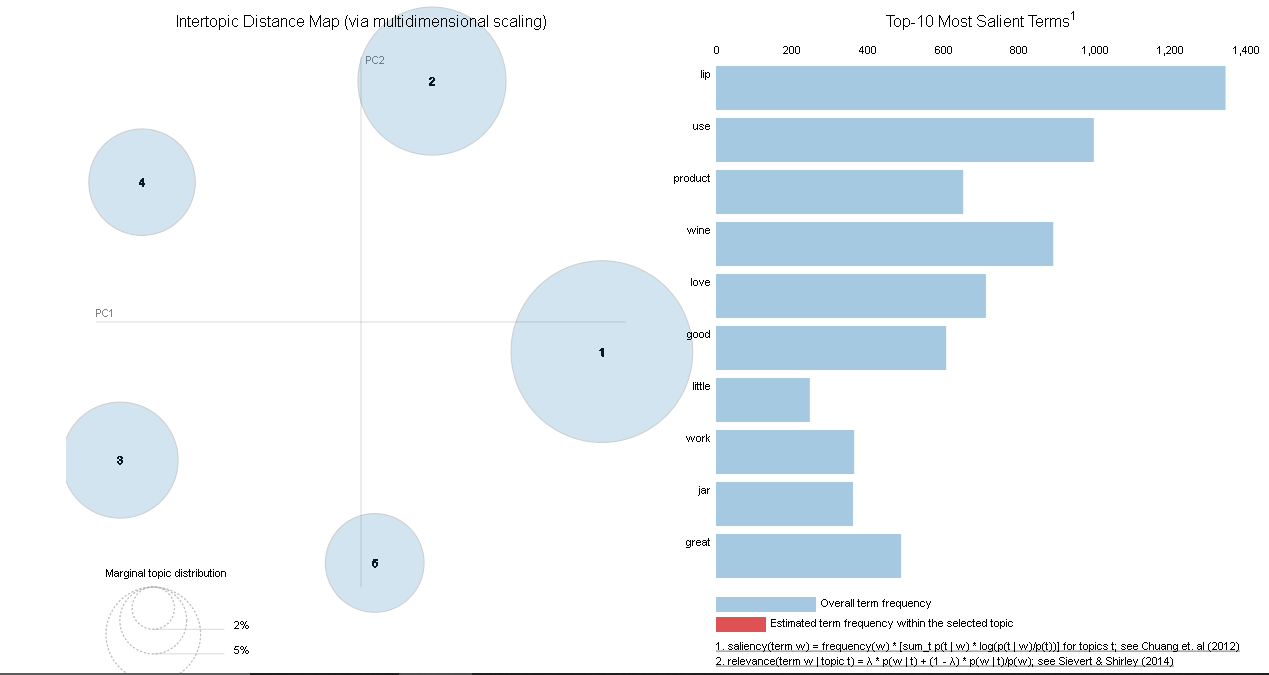

In [12]:
import wordcloud

for text in reviews['reviews_cleaned']:
    
        long_string = long_string + " ".join(text)

long_string

wordcloud = wordcloud.WordCloud()
wordcloud.generate(long_string)
wordcloud.to_image()

NameError: name 'long_string' is not defined